In [1]:
# Chapter 2 exercise from "Hands-on Machine Learning with Scikit-Learn, Keras and Tensorflow"
# Predicting the median housing price for each block within California (univariate regression problem) - 1990s data
# All data for this analysis can be found here: https://github.com/ageron/handson-ml2

# importing the required modules for reading in the data
import os
import tarfile
import urllib

download_root = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
housing_path = os.path.join("datasets","housing")
housing_url = download_root + "datasets/housing/housing.tgz"

print(housing_path)
print(housing_url)

datasets/housing
https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz


In [2]:
# in a real project, you would save this to a python file and setup a job to execute the below function periodically

def fetch_housing_data(housing_url = housing_url, housing_path = housing_path):
    os.makedirs(housing_path, exist_ok = True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
# time to load the data using pandas via creating a function

import pandas as pd

def load_housing_data(housing_path=housing_path):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()
housing.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
# it looks like 207 districts are missing the total_bedrooms feature
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
# checking out the only categorical field (ocean_proximity)
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
# inspecting the numerical fields and some summary statistics
# null values are ignored
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


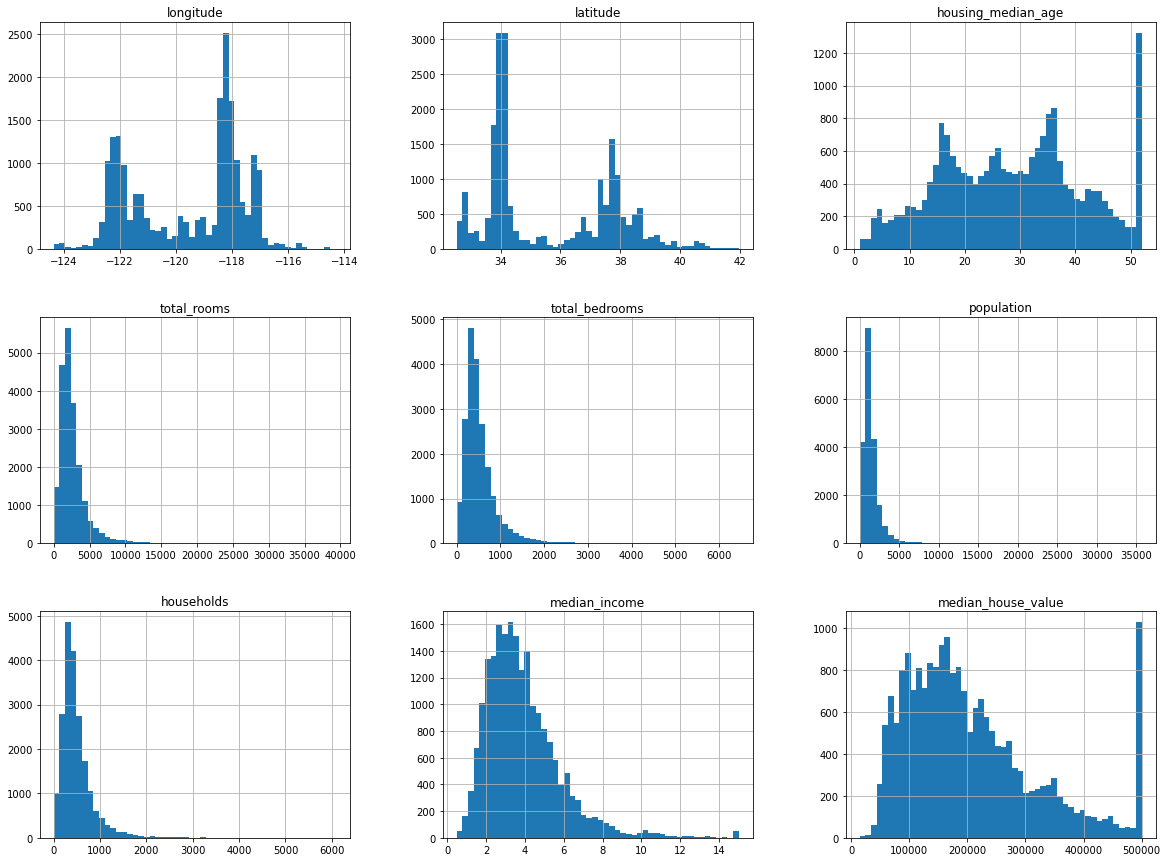

In [8]:
# plotting histograms of all numerical categories
# only in a jupyter notebook

%matplotlib inline
# the above call is telling jupyter to setup matplotlib so it uses Jupyter's own backend
# plots are then rendered within the notebook itself
# calling show() is optional in a Jupyter notebook, as Jupyter will automatically display plots when a cell is executed

import matplotlib.pyplot as plt

housing.hist(bins = 50, figsize=(20,15))
plt.show()

In [9]:
# a few notes regarding the interpretation of the above plots...
# the median income looks to be represented as a scale where each value is in thousands of dollars; e.g. 3 corresponds
# to $30,000

# many of the histograms seem to have long tail ends (to the right) which can inhibit pattern recognition; 
# we will need to improve this via distribution transformations

In [10]:
# time to go ahead and split the data
import numpy as np

# creating a splitting function that first randomly shuffles the dataset via np.random.permutation
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set))
print(len(test_set))

# while the above function will work on a single run, if you run that function again, it will generate a completely new dataset
# you could set the seed of the np.random call prior to the np.permutation (e.g. np.random.seed(42)), but this will break
# the next time one fetches a dataset

16512
4128


In [11]:
# the ultimate solution is to compute a hash of each instance's (assuming instances have a unique and immutable identifier)
# identifier and put that instance in the test set

# if the hash is lower than or equal to 20% of the maximum hash value. This ensures that the test set will remain
# consistent across multiple runs, even if you refresh the dataset. The new test set will contain 20% of the new 
# instances, but it will not contain any instance that was previously in the training set

from zlib import crc32

def test_set_check(identifier, test_ration):
    return crc32(np.int64(identifier)) & 0xfffffff < test_ration * 2**32

# the id_column must be unique; for the housing data, you could use the row index or a combination of stable features
# such as lat + long
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

# using an index and then creating an index

housing_with_id = housing.reset_index()
train_set1, test_set1 = split_train_test_by_id(housing_with_id, 0.2, "index")

housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set2, test_set2 = split_train_test_by_id(housing_with_id, 0.2, "id")

# hmmmm.. not working
print(len(train_set1), len(test_set1))
print(len(train_set2), len(test_set2))

0 20640
0 20640


In [12]:
# sklearn's train_test_split is similar to the split_train_test function developed in 2 cells above
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)
print(len(train_set), len(test_set))

16512 4128


<AxesSubplot:>

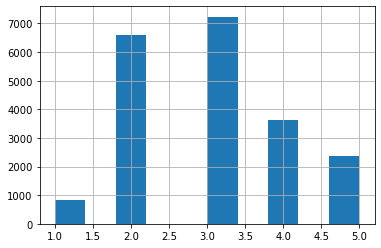

In [13]:
# after chatting with experts, the median income is an important attribute to predict the median home value
# in order to be sure that we don't have sampling bias, lets create a category feature and inspect the training
# and testing distributions

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins = [0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels = [1, 2, 3, 4, 5])

# visualizing the newly created column
housing["income_cat"].hist()

In [14]:
# now, I am ready to do stratified sampling based on the income category. For this we can use Scikit-Learn's
# StratifiedShuffleSplit class:

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [15]:
# confirming that both the training and test datasets have the same distribution of income categories
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64

In [16]:
# let's compare to if we were to just use random sampling 
# the overall population distribution
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [17]:
# random sampling to compare
train_set_not_strat, test_set_not_strat = train_test_split(housing, test_size = 0.2, random_state = 42)
train_set_not_strat["income_cat"].value_counts() / len(train_set_not_strat)

3    0.348595
2    0.317466
4    0.178537
5    0.115673
1    0.039729
Name: income_cat, dtype: float64

In [18]:
# showing the differences in sampling bias
from functools import reduce

df_strat = pd.DataFrame(strat_train_set["income_cat"].value_counts() / len(strat_train_set))
df_overall = pd.DataFrame(housing["income_cat"].value_counts() / len(housing))
df_random = pd.DataFrame(train_set_not_strat["income_cat"].value_counts() / len(train_set_not_strat))
data_frames = [df_strat, df_overall, df_random]

# merging multiple dataframes on the index
merged_dfs = pd.concat(data_frames,axis=1,sort=True)
merged_dfs.columns.values[[0, 1, 2]] = ['Stratified', 'Overall', 'Random']                                
merged_dfs['Rand. % Error'] = (merged_dfs['Random'] - merged_dfs['Overall']) / (merged_dfs['Overall']) * 100
merged_dfs['Strat. % Error'] = (merged_dfs['Stratified'] - merged_dfs['Overall']) / (merged_dfs['Overall']) * 100
merged_dfs

,Stratified,Overall,Random,Rand. % Error,Strat. % Error
1,0.039850,0.039826,0.039729,-0.243309,0.060827
2,0.318859,0.318847,0.317466,-0.433065,0.003799
3,0.350594,0.350581,0.348595,-0.566611,0.003455
4,0.176296,0.176308,0.178537,1.264084,-0.006870
5,0.114402,0.114438,0.115673,1.079594,-0.031753


In [19]:
# now, it is time to remove the income_cat attribute, so the data is back to its original state:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis = 1, inplace = True)

In [20]:
list_ref = np.arange(5)
list_ref = np.random.permutation(list_ref)
list_redacted = list_ref[:2]

print(list_ref)
print(list_redacted)

for i in range(len(list_ref) - 1):
    print(i)

[1 3 4 0 2]
[1 3]
0
1
2
3


In [21]:
print(housing.iloc[1])

longitude              -122.22
latitude                 37.86
housing_median_age          21
total_rooms               7099
total_bedrooms            1106
population                2401
households                1138
median_income           8.3014
median_house_value      358500
ocean_proximity       NEAR BAY
income_cat                   5
Name: 1, dtype: object


In [22]:
# let's go ahead and start inspecting the training data
# make a copy first, so we don't affect the training data
housing_copy = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

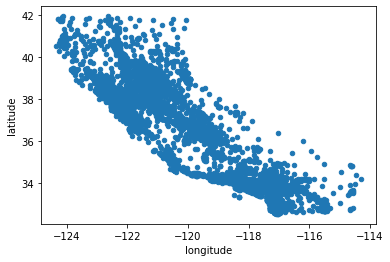

In [23]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude")

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

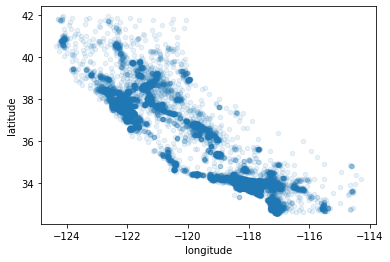

In [24]:
# setting the alpha to 0.1 in order to better visualize the density/clusters
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.1)

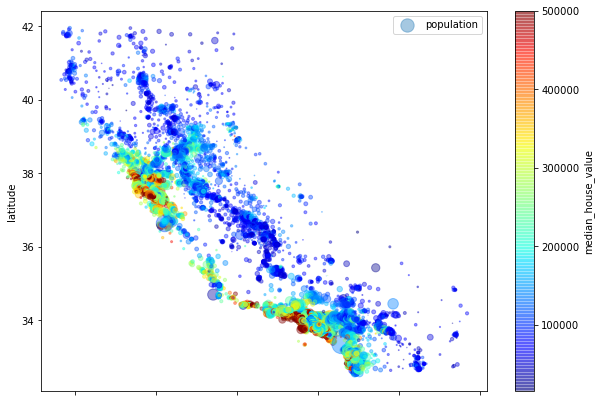

In [25]:
# now, let's check out the housing prices
# radius of each circle represents the district's population
# the color represents the price
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4, s = housing["population"]/100,
             label = "population", figsize = (10,7), c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar = True)
plt.legend()

In [26]:
# interestingly enough, the housing prices are very much related to the location (proximity to the ocean) and population density
# time to understand the correlations between features
corr_matrix = housing.corr()

# check out how each variable corresponds to the median house value
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

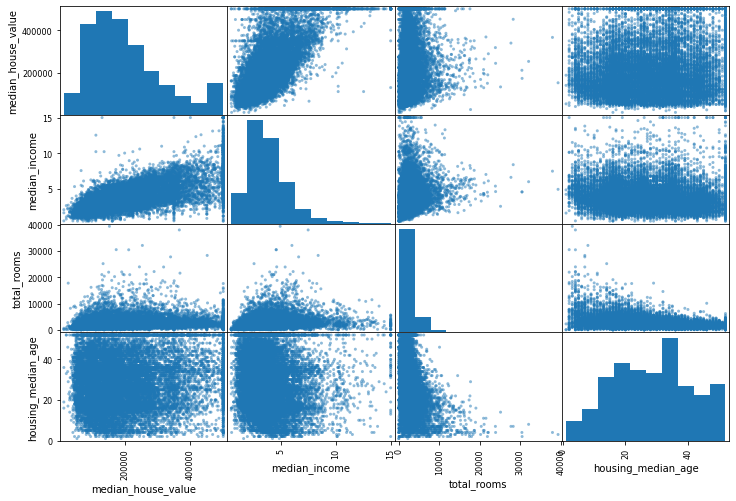

In [27]:
# the correlation coefficient only measures linear relationships ("if x goes up, then y generally goes up/down"); 
# it is unable to capture nonlinear relationships between variables
# using pandas' scatter_matrix to visualize numerical variables' correlation
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing_copy[attributes], figsize = (12,8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

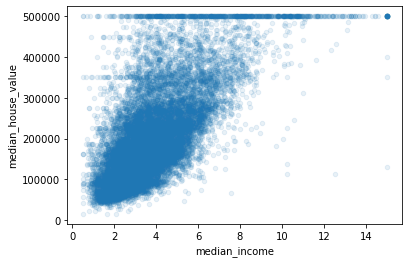

In [28]:
# the most promising attribute to predict median house value is the median income, so let's zoom in on their
# correlation scatterplot

housing_copy.plot(kind = "scatter", x = "median_income", y = "median_house_value", alpha = 0.1)

In [29]:
# notice some interesting things in the above plot (horizontal clustering along 500,000 (cap), 450,000 and 350,000)
# may want to try removing these values/districts to prevent the algorithms from learning to reproduce these data quirks
# experimenting with attribute combinations
# creating new attributes

housing_copy["rooms_per_household"] = housing_copy["total_rooms"]/housing_copy["households"]
housing_copy["bedrooms_per_room"] = housing_copy["total_bedrooms"]/housing_copy["total_rooms"]
housing_copy["population_per_household"] = housing_copy["population"]/housing_copy["households"]

# now, let's inspect the correlation matrix again
corr_matrix = housing_copy.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [30]:
# separating predictors from the target variable
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

In [31]:
# imputing missing numerical values
# you have three options:
# housing.dropna(subset = ["total_bedrooms"]) - dropping all observations that have a null value
# housing.drop("total_bedrooms", axis = 1) - completely removing the attribute
# housing ["total_bedrooms"].fillna(median, inplace = True) - filling with median values from training dataset

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = "median")
# dropping the non-numerical columns, as the imputer only works on numerical columns
housing_num = housing.drop("ocean_proximity", axis = 1)
# fitting the imputer instance to the training data
imputer.fit(housing_num)
# after executing the above line of code, the imputer computes the median of each numerical attribute
# and stores it in its statistics_ instance variable 
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [32]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [33]:
# transforming the training dataset by replacing missing values with learned medians (an array)
X = imputer.transform(housing_num)
# putting the array back into the datafram
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = housing_num.index)

In [34]:
print(X.shape)
print(X)

(16512, 8)
[[-121.89     37.29     38.     ...  710.      339.        2.7042]
 [-121.93     37.05     14.     ...  306.      113.        6.4214]
 [-117.2      32.77     31.     ...  936.      462.        2.8621]
 ...
 [-116.4      34.09      9.     ... 2098.      765.        3.2723]
 [-118.01     33.82     31.     ... 1356.      356.        4.0625]
 [-122.45     37.77     52.     ... 1269.      639.        3.575 ]]


In [35]:
print(housing_tr.shape)
housing_tr.head(5)

(16512, 8)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [36]:
# time to deal with the one categorical value
housing_cat = housing[["ocean_proximity"]]
housing_cat.head()

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


In [37]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [38]:
# the above encoding wouldn't be considered applicable to our current dataset, as the categories are not ordered per say
# let's use one-hot encoding instead
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [39]:
# the output is a sparse matrix because it takes a lot of memory/space to store zeros; instead, Scipy stores
# the 2d array as a sparse matrix that only stores the non-zero values (1s); if you want to convert it to a dense
# 2d array, just call the toarray() method
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [40]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [41]:
# if a categorical variable has a high cardinality/# of possible categories, then one-hot encoding will result 
# in a large number of input features. This may slow down the training time and degrade performance
# in order to reduce the computational spend, it might make sense to take one of the following, alternative approaches
# 1) replace the categorical variable with useful numerical features (e.g. using distance from the ocean instead of text)
# 2) you could replace each category with a learnable, low-dimensional vector called an embedding. Each category's representation
# would be learned during training

In [42]:
# creating a custom transformer to add in the engineered attributes
from sklearn.base import BaseEstimator, TransformerMixin

# column position to reference in the transform function
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

# dynamically retreiving the indices for specified columns instead of hardcoding like above
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # get the column indices

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__ (self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y = None):
        return self # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        # check to see if a non-null/non-NaN value is present
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

# in this example, the transformer has one hyperparamter, add_bedrooms_per_room, set to True by default
# it is often helpful to provide sensible defaults). This hyperparameter will allow you to easily find out whether adding
# this attribute helps the ML algorithms or not; add a hyperparameter gate to any data preparation step that you
# are not 100% sure about

In [43]:
# creating a pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
               ('imputer', SimpleImputer(strategy = "median")),
               ('attribs_adder', CombinedAttributesAdder()),
               ('std_scalar', StandardScaler()),
               ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

# all but the last estimator must be transformers (i.e., they must have a fit_transform() method)

In [44]:
# using categorical transformer in the pipeline
# the ColumnTransformer constructor requires a list of tuples, where each tuple contains a name, a transformer and a list
# of names (or indices) of columns that the transformer should be applied to
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [45]:
# Training and Evaluating on the Training Set

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [46]:
# trying out the working model on a few instances from the training set

some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [47]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [48]:
# time to measure the error via RSME

from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rsme = np.sqrt(lin_mse)
lin_rsme

68628.19819848923

In [49]:
# clearly, the above model is underfitting the data... median house values range between 120,000 and 265,000; a 68,628
# error is significant

# let's test out a more complex model to see if that works

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rsme = np.sqrt(tree_mse)
tree_rsme

0.0

In [50]:
# wow.. this model is wildly overfit.. time to better train the model using cross-validation

from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv = 10)
tree_rsme_scores = np.sqrt(-scores)

# Scikit-Learn's cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better)
# , so the scoring function is actually the opposite of the MSE  

In [51]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())
    
display_scores(tree_rsme_scores)

Scores: [70483.13186774 66733.1684072  70889.42224156 69995.2285709
 72442.38414602 75680.01139704 70658.9564399  70671.80248375
 76909.20087644 69911.42001576]
Mean: 71437.47264463022
Standard Deviation: 2790.907358291087


In [52]:
# it looks like the tree-based algo is actually performing worse than the linear_reg model
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv = 10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)


Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard Deviation: 2731.674001798344


In [53]:
# the tree model is overfitting so badly that it performs worse than the lin_reg model 
# let's try one last model... RandomForestRegressor

from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

# just checking the training data set
housing_predictions_forest = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions_forest)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

# scoring via cross-validation testing; the random_forest_regressor definitely performs better than the lin_reg and 
# decision_tree_regressor
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv = 10)
forest_rmse_scores = np.sqrt(-forest_scores)
forest_rmse_scores
display_scores(forest_rmse_scores)

# the model performs much better on the training set versus the validation sets, so that means that 
# the model is still overfitting on the training set: in order to remedy this situation, there are a few options:
# 1) simplify the model
# 2) constrain it (regularize)
# 3) get a lot more training data
# the goal of this stage is to short-list 2 to 5 models


Scores: [49483.18010215 47368.05262616 50044.48074489 52579.20373205
 49613.00770691 53187.40530555 48764.04368443 48056.44933772
 53128.22210936 50436.70406212]
Mean: 50266.074941136045
Standard Deviation: 1968.0279032957183


In [54]:
# fitting to the training data score... you can see it is much better than the cross-validation
forest_rmse

18621.91500691021

In [55]:
# how to save and load a model

import joblib

# joblib.dump(my_model, "my_model.pkl")
# and later...
# my_model_loaded = joblib.load("my_model.pkl")

In [56]:
# Fine-Tuning the Model using Scikit-Learn's GridSearchCV

from sklearn.model_selection import GridSearchCV

# this combination of selected hyperparameters and conditions yields 90 rounds of training
# first yields: 3 X 4 = 12 X 5 CV = 60
# second yields: 2 X 3 = 6 X 5 CV = 30
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators':[3, 10], 'max_features':[2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv = 5, 
                           scoring = 'neg_mean_squared_error',
                           return_train_score = True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [57]:
# returning the best parameters per the trained models
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [58]:
# you can also get the bet estimator directly:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [59]:
# evaluation scores
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64531.7626579728 {'max_features': 2, 'n_estimators': 3}
55911.81705675814 {'max_features': 2, 'n_estimators': 10}
52652.534993369794 {'max_features': 2, 'n_estimators': 30}
59209.91971029852 {'max_features': 4, 'n_estimators': 3}
53720.61562356326 {'max_features': 4, 'n_estimators': 10}
50641.249268477615 {'max_features': 4, 'n_estimators': 30}
59094.72855565338 {'max_features': 6, 'n_estimators': 3}
51988.78814905088 {'max_features': 6, 'n_estimators': 10}
50067.698287772655 {'max_features': 6, 'n_estimators': 30}
59178.99854887003 {'max_features': 8, 'n_estimators': 3}
52045.1005139877 {'max_features': 8, 'n_estimators': 10}
50177.11004512338 {'max_features': 8, 'n_estimators': 30}
61447.06462366196 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54263.65511591738 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59793.715946839795 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52837.79358236671 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

In [60]:
# don't forget that you can treat some of the data preparation steps as hyperparameters. For example, the grid search
# will automatically find out whether or not to add a feature you were not sure about. It may similiarly be used to 
# automatically find the best way to handle outliers, missing features, feature selection and more

In [61]:
# analyze the best models and their errors

feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.70222865e-02, 6.95007604e-02, 4.16690756e-02, 1.81036190e-02,
       1.75785827e-02, 1.80162015e-02, 1.62223697e-02, 3.29577427e-01,
       5.97923260e-02, 1.07371200e-01, 7.83915081e-02, 1.13363588e-02,
       1.47909682e-01, 9.90161345e-05, 2.55847578e-03, 4.85111202e-03])

In [62]:
# time to display these importance scores next to their corresponding attribute names:

extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse = True)

[(0.32957742654270683, 'median_income'),
 (0.14790968171546665, 'INLAND'),
 (0.10737119951369622, 'pop_per_hhold'),
 (0.07839150812127302, 'bedrooms_per_room'),
 (0.07702228649025207, 'longitude'),
 (0.0695007603598129, 'latitude'),
 (0.05979232597250907, 'rooms_per_hhold'),
 (0.041669075570150586, 'housing_median_age'),
 (0.018103619040877594, 'total_rooms'),
 (0.0180162015268035, 'population'),
 (0.017578582670956452, 'total_bedrooms'),
 (0.016222369722257973, 'households'),
 (0.011336358817132937, '<1H OCEAN'),
 (0.004851112022537148, 'NEAR OCEAN'),
 (0.0025584757790553018, 'NEAR BAY'),
 (9.901613451185985e-05, 'ISLAND')]

In [63]:
# as you can see, some features are not informative; it may make sense to drop these features and re-fit the training dataset
# also, consider accounting for outliers to help build a more generalized model 
# now, it is time to go ahead and apply the trained model to the test dataset; ensure you do not fit the full_pipeline
# on the test dataset.. just reference the transform() method

final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis = 1)
Y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(Y_test, final_predictions)
final_rsme = np.sqrt(final_mse)

In [ ]:
# computing a 95% confidence interval for the generalization error

from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, 
                         loc = squared_errors.mean(), 
                         scale = stats.sem(squared_errors)))

In [ ]:
# now, it is time to load and deploy the model into a production system
# there are various ways to do this...
# 1) save the trained model via joblib
# 2) wrap the model within a dedicated web service that your web application can query through a REST API
# 3) deploy the model in the cloud (Google Cloud AI Platform)
# 3a) just save the model using joblib and upload it to Google Cloud Storage
# 3b) then, head over to Google Cloud AI Platform and create a new model version, pointing it to the GCS file; load balancing and 
# scaling is taken care of via google's service
# 3c) it'll take JSON requests containing the input data (e.g. of a district) and returns JSON responses containing
# predictions